## TESS light curve fit
Example of using some of the lmfit Model classes in pycheops.models to fit a TESS light curve of an eclipsing binary system.

In [1]:
%pylab inline
from astroquery.mast import Observations
from astropy.table import Table, Column
from pycheops import models
from pycheops.ld import stagger_power2_interpolator
import warnings
from astroquery.mast.core import NoResultsWarning
warnings.simplefilter('ignore',NoResultsWarning)

Populating the interactive namespace from numpy and matplotlib


#### Target information

In [2]:
# 1SWASP J205438.27-320723.6
TIC = 92349924 
T0 = 1325.6681  # Time of mid-transit, BJD-2457000
P = 8.800694
pwidth = 0.018  # Width of primary eclipse
phsec = 0.536   # Phase of secondary eclipse
swidth = 0.017  # Width of secondary eclipse
Teff = 6334     # Primary star effective temperature

#### Download TESS data

In [21]:
flux_column = 'PDCSAP_FLUX'
# flux_column = 'SAP_FLUX'

quality_bitmask=1130799  # "default": cadences with severe quality issues will be ignored
# quality_bitmask=1664431 #  more conservative choice of flags to ignore - this is known to remove good data.

tjd = []
flux = []
for obs in Observations.query_criteria(filters=["TESS"],target_name=TIC):
    obslist = Observations.get_product_list(obs['obsid'])
    m=Observations.download_products(obslist[obslist['description'] == "Light curves"])
    if m is not None:
        data = Table.read(m['Local Path'][0])
        iok = ( ((data['QUALITY'] & quality_bitmask) == 0) &
                isfinite(data[flux_column])).nonzero()
        data = data[iok]
        tjd=np.append(tjd,array(data['TIME']))  
        flx=data[flux_column] 
        flux=np.append(flux,flx/median(flx))


INFO: Found cached file ./mastDownload/TESS/tess2018206045859-s0001-0000000092349924-0120-s/tess2018206045859-s0001-0000000092349924-0120-s_lc.fits with expected size 2039040. [astroquery.query]


#### Divide-out polynomial fit to variations between eclipses

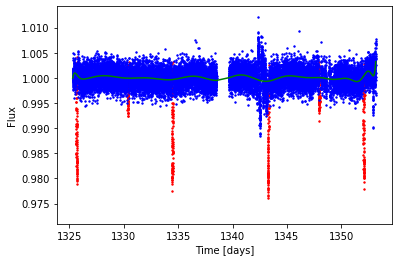

In [22]:
npoly = 24
phase = ((((tjd - (T0))/P % 1)+0.25) % 1) - 0.25
mask_out = ((abs(phase) > pwidth/2) & (abs(phase-phsec)>swidth/2)).nonzero()
mask_in = ((abs(phase) <= pwidth/2) | (abs(phase-phsec)<swidth/2)).nonzero()
x = tjd-nanmedian(tjd)
pt = np.polyfit(x[mask_out],flux[mask_out],npoly)

fig1,ax1 = subplots()
ax1.scatter(tjd[mask_in],flux[mask_in],s=2,c='r')
ax1.scatter(tjd[mask_out],flux[mask_out],s=2,c='b')
ax1.plot(tjd,np.polyval(pt,x),c='g')
ax1.set_xlabel('Time [days]')
ax1.set_ylabel('Flux')

flux = flux/np.polyval(pt,x)

#### Construct model

In [11]:
Mfac = models.FactorModel()
Mtra = models.TransitModel(prefix='t_')
Mecl = models.EclipseModel()
M = Mfac*Mtra*Mecl
pars = M.make_params()

pars.add('T_0', value = T0, min = T0-0.25*P,max=T0+0.25*P)
pars.add('P', value = P, min = 0.99*P,max = 1.01*P)
pars.add('D', value = 0.02, min = 0.01,max = 0.04)
pars.add('W', value = 0.02, min = 0.01,max = 0.04)
pars.add('b', value = 0.9, min = 0,max = 1)
pars.add('f_s', value = 0.00, min = -0.5,max = 0.5)
pars.add('f_c', value = 0.234, min = -0.5,max = 0.5)
pars.add('L', value = 0.005, min = 0.0001,max = 0.1)

# Fix transit model parameters to eclipse model parameters where possible
for p in ['T_0','P','D','W','b','f_c','f_s']:
    pars.add('t_{}'.format(p), expr = p)
LimbDarkeningInterpolator = stagger_power2_interpolator(passband='TESS')
c2, a2, h_1, h_2 = LimbDarkeningInterpolator(Teff,4.0,0.0)
pars.add('t_h_1', value = h_1, vary=False)
pars.add('t_h_2', value = h_2, vary=False)

for p in pars:
    if pars[p].vary: print(pars[p])

<Parameter 'c', 1.0, bounds=[0:inf]>
<Parameter 'T_0', 1325.6681, bounds=[1323.4679265000002:1327.8682735]>
<Parameter 'P', 8.800694, bounds=[8.71268706:8.88870094]>
<Parameter 'D', 0.02, bounds=[0.01:0.04]>
<Parameter 'W', 0.02, bounds=[0.01:0.04]>
<Parameter 'b', 0.9, bounds=[0:1]>
<Parameter 'L', 0.005, bounds=[0.0001:0.1]>
<Parameter 'f_c', 0.234, bounds=[-0.5:0.5]>
<Parameter 'f_s', 0.0, bounds=[-0.5:0.5]>


#### Plot initial fit

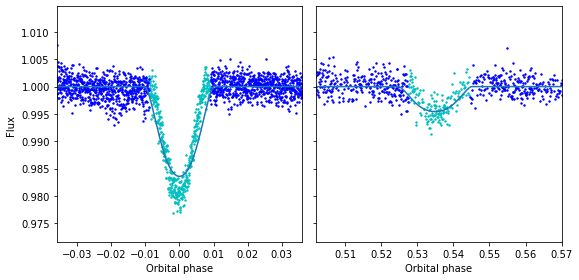

In [12]:
fig2, ax2 = subplots(ncols=2,figsize=(8,4),sharey=True)
ph_plot = linspace(-0.5,1.5,10001)
t_plot = T0 + ph_plot*P
f_plot = M.eval(pars,t=t_plot)
for a in ax2:
    a.scatter(phase[mask_in],flux[mask_in],s=2,c='c')
    a.scatter(phase[mask_out],flux[mask_out],s=2,c='b')
    a.set_xlabel('Orbital phase')
    a.plot(ph_plot,f_plot)

ax2[0].set_ylabel('Flux ')
ax2[0].set_xlim(-2*pwidth,2*pwidth)
ax2[1].set_xlim(phsec-2*swidth,phsec+2*swidth);
fig2.tight_layout();

#### Least-squares fit

In [13]:
result = M.fit(flux,pars,t=tjd)
print(result.fit_report())

[[Model]]
    ((Model(factor) * Model(_transit_func, prefix='t_')) * Model(_eclipse_func))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 546
    # data points      = 18094
    # variables        = 9
    chi-square         = 0.05814644
    reduced chi-square = 3.2152e-06
    Akaike info crit   = -228837.196
    Bayesian info crit = -228766.966
[[Variables]]
    d2fdt2:      0 (fixed)
    dfdt:        0 (fixed)
    dfdcosphi:   0 (fixed)
    dfdsinphi:   0 (fixed)
    dfdcos2phi:  0 (fixed)
    dfdsin2phi:  0 (fixed)
    d2fdy2:      0 (fixed)
    d2fdxdy:     0 (fixed)
    d2fdx2:      0 (fixed)
    dfdy:        0 (fixed)
    dfdx:        0 (fixed)
    c:           1.00000006 +/- 1.3528e-05 (0.00%) (init = 1)
    t_T_0:       1325.66643 +/- 0.41061917 (0.03%) == 'T_0'
    t_P:         8.79941516 +/- 2.5859e-04 (0.00%) == 'P'
    t_D:         0.03905160 +/- 7.3261e-04 (1.88%) == 'D'
    t_W:         0.01550904 +/- 3.6849e-04 (2.38%) == 'W'
    t_b:         

#### Plot best fit

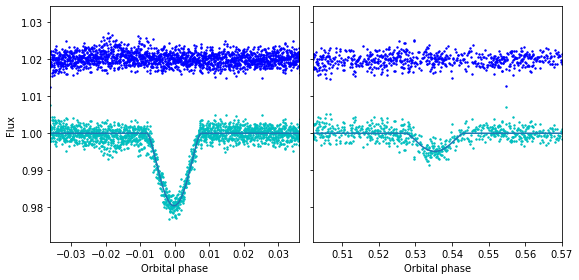

In [14]:
fig2, ax2 = subplots(ncols=2,figsize=(8,4),sharey=True)
ph_plot = linspace(-0.5,1.5,10001)
t_plot = T0 + ph_plot*P
f_plot = M.eval(result.params,t=t_plot)
for a in ax2:
    a.scatter(phase,flux,s=2,c='c')
    a.scatter(phase,result.residual+1.02,s=2,c='b')
    a.set_xlabel('Orbital phase')
    a.plot(ph_plot,f_plot)

ax2[0].set_ylabel('Flux ')
ax2[0].set_xlim(-2*pwidth,2*pwidth)
ax2[1].set_xlim(phsec-2*swidth,phsec+2*swidth);
fig2.tight_layout();

&copy; Pierre Maxted, Keele University (2019)